# Multi-period OPF example

Multi-period OPF example with and without ESR.

No update on renewable generation and electrification load.

In [14]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import nygrid.nygrid as ng_grid
import nygrid.run_nygrid as ng_run
import nygrid.plots as ng_plots

In [15]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid', '2018NewParams')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')
print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid/2018NewParams
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

### Read generator profiles

In [16]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')
verbose = True

In [17]:
# Read grid property file
grid_prop = ng_run.read_grid_prop(grid_data_dir)

# Read load and generation profiles
grid_profile = ng_run.read_grid_profile(grid_data_dir, start_date.year)

In [18]:
# Decrease external load by 50%
# bus_idx_ext = grid_prop['bus_prop'][grid_prop['bus_prop']['BUS_ZONE'].isin(['NE','PJM','IESO'])]['BUS_I']
# load_profile_new = grid_profile['load_profile'].copy()
# load_profile_new.loc[:, bus_idx_ext] = load_profile_new.loc[:, bus_idx_ext] * 0.1
# grid_profile['load_profile'] = load_profile_new

In [19]:
# Decrease external generation cost by 50%
change_index = grid_prop["gen_fuel"]["GEN_FUEL"].isin(
    ["Import_Import"]).to_numpy()

gencost1_profile_new = grid_profile['gencost1_profile'].copy()
gencost1_profile_new.loc[:, change_index] = gencost1_profile_new.loc[:, change_index] * 0.1
grid_profile['gencost1_profile'] = gencost1_profile_new

In [20]:
# Increase FO2, KER and BIT generation costs
change_index = grid_prop["gen_fuel"]["GEN_FUEL"].isin(
    ["CT_FO2", "CT_KER", "ST_BIT"]).to_numpy()

gencost0_profile_new = grid_profile['gencost0_profile'].copy()
gencost0_profile_new.loc[:, change_index] = gencost0_profile_new.loc[:, change_index] * 3
grid_profile['gencost0_profile'] = gencost0_profile_new

gencost1_profile_new = grid_profile['gencost1_profile'].copy()
gencost1_profile_new.loc[:, change_index] = gencost1_profile_new.loc[:, change_index] * 3
grid_profile['gencost1_profile'] = gencost1_profile_new

gencost_startup_profile_new = grid_profile['gencost_startup_profile'].copy()
gencost_startup_profile_new.loc[:, change_index] = gencost_startup_profile_new.loc[:, change_index] * 3
grid_profile['gencost_startup_profile'] = gencost_startup_profile_new

## Multi-period OPF

### Without initial conditions

In [21]:
# Only run for one day
d = 0
start_datetime_0 = timestamp_list[d]
# end_datetime_0 = start_datetime_0 + timedelta(hours=24*364+23)
end_datetime_0 = start_datetime_0 + timedelta(hours=24*7+23)
print(f'Start time: {start_datetime_0}')
print(f'End time: {end_datetime_0}')

Start time: 2018-01-01 00:00:00
End time: 2018-01-08 23:00:00


In [22]:
# Create NYGrid object
nygrid_sim_0 = ng_grid.NYGrid(grid_prop=grid_prop,
                              start_datetime=start_datetime_0,
                              end_datetime=end_datetime_0,
                              verbose=verbose)

# Set load and generation time series data
nygrid_sim_0.set_load_sch(grid_profile['load_profile'])
# nygrid_sim_0.set_gen_mw_sch(grid_profile['gen_profile'])
nygrid_sim_0.set_gen_max_sch(grid_profile['genmax_profile'])
# nygrid_sim_0.set_gen_min_sch(grid_profile['genmin_profile'])
# nygrid_sim_0.set_gen_ramp_sch(grid_profile['genramp30_profile'])
nygrid_sim_0.set_gen_cost_sch(grid_profile['gencost0_profile'],
                              grid_profile['gencost1_profile'])
nygrid_sim_0.set_gen_cost_startup_sch(grid_profile['gencost_startup_profile'])
# nygrid_sim_0.set_gen_cost_shutdown_sch(grid_profile['gencost_shutdown_profile'])

if 'genmax_profile_vre' in grid_profile:
    nygrid_sim_0.set_vre_max_sch(grid_profile['genmax_profile_vre'])
else:
    print('No VRE generation data.')

# Relax branch flow limits
nygrid_sim_0.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_0.set_gen_init_data(gen_init=None)

# Set generator initial unit commitment condition
init_gen_commit = np.zeros(nygrid_sim_0.NG_avail)
nygrid_sim_0.set_gen_init_cmt_data(gen_init_cmt=init_gen_commit)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 5_000,
    # 'PenaltyForInterfaceMWViolation': 5_000
}

nygrid_sim_0.set_options(options)

# Solve DC OPF
nygrid_sim_0.solve_dc_opf()

# Get results
results_0 = nygrid_sim_0.get_results_dc_opf()

No VRE generation data.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-08
skipping further warning of this kind
Read LP format model from file /tmp/tmptvlhckb7.pyomo.lp
Reading time = 1.73 seconds
x1: 618795 rows, 424512 columns, 2535206 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 618795 rows, 424512 columns and 2535206 nonzeros
Model fingerprint: 0x28031f6a
Variable types: 288576 continuous, 135936 integer (135936 binary)
Coefficient statistics:
  Matrix range     [3e-06, 1e+01]
  Objective range  [5e-17, 8e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-17, 1e+03]
Presolve removed 594106 rows and 334464 columns
Presolve time: 0.85s
Presolved: 24689 rows, 90048 columns, 219164 nonzeros
Variable types: 90048 continuous, 0 integer (0 binary)

Deterministic concurrent LP optimize

In [23]:
print("s_ramp_up", results_0['s_ramp_up'].sum())
print("s_ramp_down", results_0['s_ramp_down'].sum())
print("s_over_gen", results_0['s_over_gen'].sum())
print("s_load_shed", results_0['s_load_shed'].sum())
print("s_if_max", results_0['s_if_max'].sum())
print("s_if_min", results_0['s_if_min'].sum())
print("s_br_max", results_0['s_br_max'].sum())
print("s_br_min", results_0['s_br_min'].sum())
print("s_esr_pcrg", results_0['s_esr_pcrg'].sum())
print("s_esr_pdis", results_0['s_esr_pdis'].sum())
print("s_esr_soc_min", results_0['s_esr_soc_min'].sum())
print("s_esr_soc_max", results_0['s_esr_soc_max'].sum())
print("s_esr_soc_overt", results_0['s_esr_soc_overt'].sum())
print("s_esr_soc_undert", results_0['s_esr_soc_undert'].sum())

s_ramp_up 3.726706443440975e-12
s_ramp_down 4.188316360398403e-12
s_over_gen 0.0
s_load_shed 0.0
s_if_max 172538.80330929556
s_if_min 960.8495862959937
s_br_max 0.0
s_br_min 0.0
s_esr_pcrg 0.0
s_esr_pdis 0.0
s_esr_soc_min 0.0
s_esr_soc_max 0.0
s_esr_soc_overt 0.0
s_esr_soc_undert 6631.0999999999985


In [24]:
# import pickle
# # Save simulation nygrid_results to pickle
# filename = f'nygrid_sim_yearly.pkl'
# with open(os.path.join(results_dir, filename), 'wb') as f:
#     pickle.dump(results_0, f)

## Process the results

### Costs

In [25]:
print(f'Total cost: {results_0["total_cost"].sum():.2f}')
print(f'Total penalty: {results_0["total_penalty"].sum():.2f}')
print(f'Total cost and penalty: {results_0["total_cost_penalty"].sum():.2f}')

print(f'Gen cost: {results_0["gen_cost"].sum():.2f}')
print(f'Gen no load cost: {results_0["gen_cost_noload"].sum():.2f}')
print(f'Gen startup cost: {results_0["gen_cost_startup"].sum():.2f}')
print(f'Gen shutdown cost: {results_0["gen_cost_shutdown"].sum():.2f}')
print(f'ESR cost: {results_0["esr_cost"].sum():.2f}')

print(f'Over generation penalty: {results_0["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_0["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_0["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_0["ramp_down_penalty"].sum():.2f}')
print(f'Interface max penalty: {results_0["if_max_penalty"].sum():.2f}')
print(f'Interface min penalty: {results_0["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_0["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_0["br_min_penalty"].sum():.2f}')

print(f'ESR Charging power penalty: {results_0["esr_pcrg_penalty"].sum():.2f}')
print(f'ESR Discharging power penalty: {results_0["esr_pdis_penalty"].sum():.2f}')
print(f'ESR SOC max penalty: {results_0["esr_soc_max_penalty"].sum():.2f}')
print(f'ESR SOC min penalty: {results_0["esr_soc_min_penalty"].sum():.2f}')
print(f'ESR SOC over target penalty: {results_0["esr_soc_overt_penalty"].sum():.2f}')
print(f'ESR SOC under target penalty: {results_0["esr_soc_undert_penalty"].sum():.2f}')


Total cost: 392341043.88
Total penalty: 1768152.03
Total cost and penalty: 394109195.91
Gen cost: 392341119.92
Gen no load cost: 37768287.07
Gen startup cost: 1543864.30
Gen shutdown cost: 0.00
ESR cost: -76.04
Over generation penalty: 0.00
Load shed penalty: 0.00
Ramp up penalty: 0.00
Ramp down penalty: 0.00
Interface max penalty: 1725388.03
Interface min penalty: 9608.50
Branch max penalty: 0.00
Branch min penalty: 0.00
ESR Charging power penalty: 0.00
ESR Discharging power penalty: 0.00
ESR SOC max penalty: 0.00
ESR SOC min penalty: 0.00
ESR SOC over target penalty: 0.00
ESR SOC under target penalty: 33155.50


### LMP

In [26]:
# # Create a dict where key is busIdx and value is zoneID
# bus_zone_alloc = nygrid_sim_0.grid_prop['bus_prop'].set_index(
#     'BUS_I').to_dict()['BUS_ZONE']
# bus_names = list(bus_zone_alloc.keys())
# bus_names_str = [f'Bus{i}' for i in bus_names]

In [27]:
# lmp_0 = results_0['LMP']
# lmp_0.columns = bus_names

# # Aggregate LMPs by zone
# lmp_0_zone = lmp_0.T.groupby(bus_zone_alloc).mean().T

# lmp_1 = results_1['LMP']
# lmp_1.columns = bus_names

# # Aggregate LMPs by zone
# lmp_1_zone = lmp_1.T.groupby(bus_zone_alloc).mean().T

In [28]:
# fig, axs = plt.subplots(7, 2, figsize=(12, 12), 
#                         sharex='all', sharey='all',
#                         layout='constrained')
# # Plot LMPs w/o ESR
# for i, ax in enumerate(axs.flat):
#     lmp_0_zone.iloc[:, i].plot(ax=ax, label='Day 1 w/o IC', alpha=0.5)
#     lmp_1_zone.iloc[:, i].plot(ax=ax, label='Day 2 w/ IC', alpha=0.5)
#     ax.set_title(lmp_1_zone.columns[i])
#     ax.legend()
# fig.suptitle('LMP')

### ESR

In [29]:
ii = 7
crg_max = grid_prop['esr_prop']['ESR_CRG_MAX'].iloc[ii]
dis_max = grid_prop['esr_prop']['ESR_DIS_MAX'].iloc[ii]
crg_eff = grid_prop['esr_prop']['ESR_CRG_EFF'].iloc[ii]
dis_eff = grid_prop['esr_prop']['ESR_DIS_EFF'].iloc[ii]
soc_init = grid_prop['esr_prop']['ESR_SOC_INI'].iloc[ii]
soc_max = grid_prop['esr_prop']['ESR_SOC_MAX'].iloc[ii]

print(f'crg_max: {crg_max}, dis_max: {dis_max}, crg_eff: {crg_eff}, dis_eff: {dis_eff}, soc_init: {soc_init}, soc_max: {soc_max}')


crg_max: 18.5, dis_max: 18.5, crg_eff: 0.85, dis_eff: 0.85, soc_init: 37, soc_max: 74


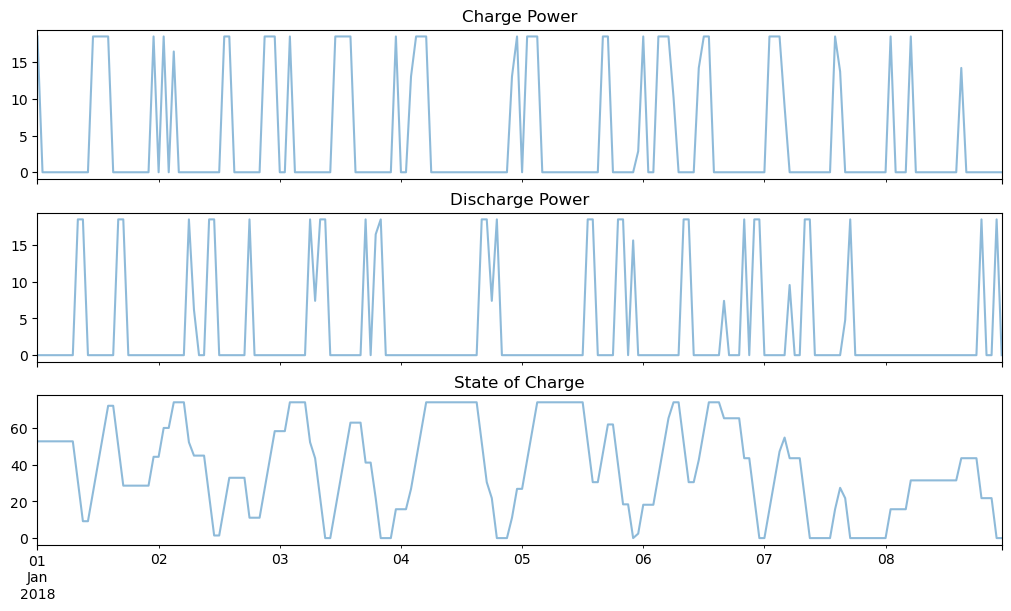

In [30]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6),
                       sharex=True, layout='constrained')

results_0['esrPCrg'].iloc[:, ii].plot(ax=axs[0], label='Day 1 w/o IC', alpha=0.5)
results_0['esrPDis'].iloc[:, ii].plot(ax=axs[1], label='Day 1 w/o IC', alpha=0.5)
results_0['esrSOC'].iloc[:, ii].plot(ax=axs[2], label='Day 1 w/o IC', alpha=0.5)

# results_1['esrPCrg'].iloc[:, ii].plot(ax=axs[0], label='Day 2 w/ IC', alpha=0.5)
# results_1['esrPDis'].iloc[:, ii].plot(ax=axs[1], label='Day 2 w/ IC', alpha=0.5)
# results_1['esrSOC'].iloc[:, ii].plot(ax=axs[2], label='Day 2 w/ IC', alpha=0.5)

titles = ['Charge Power', 'Discharge Power', 'State of Charge']
for i, ax in enumerate(axs):
    ax.set_title(titles[i])